## Post MVP

There are a few things I want to do:
* Increase my sample size to include more than just 'single family residential' properties. Things like bungalows, mobile homes, and town houses.
* After cleaning the new data, explore new features like property type, location (lat, long), county, and decade built.
* Form new hypotheses and test them. Will need at least one t-test.
* Determine the most useful features for modeling
* Create different models and see how they stack up against my MVP model.

### Getting the new data

* Will need to update the sql query.

In [1]:
import numpy as np 
import pandas as pd
import env
import wrangle
import explore
import model
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

My new query will include homes of type:
* 261	Single Family Residential
* 262	Rural Residence
* 263	Mobile Home
* 264	Townhouse
* 265	Cluster Home
* 268   Row House
* 273   Bungalow
* 275	Manufactured, Modular, Prefabricated Homes
* 276	Patio Home
* 279	Inferred Single Family Residential

In [2]:
zillow_query = """
    SELECT * FROM properties_2017
    LEFT JOIN predictions_2017 ON predictions_2017.parcelid = properties_2017.parcelid
    LEFT JOIN heatingorsystemtype ON heatingorsystemtype.heatingorsystemtypeid = properties_2017.heatingorsystemtypeid
    LEFT JOIN propertylandusetype ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
    WHERE (properties_2017.propertylandusetypeid IN (261, 262, 263, 264, 265, 266, 268, 273, 275, 276, 279))
        AND (predictions_2017.transactiondate >= '2017-05-01'
            AND predictions_2017.transactiondate <= '2017-08-31');
"""

In [3]:
zillow_url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/zillow'

In [4]:
#Get the new data
zillow = pd.read_sql(zillow_query, zillow_url)
zillow.head()

id  parcelid  airconditioningtypeid  architecturalstyletypeid  \
0  2026522  14634203                    1.0                       NaN   
1   616260  11721753                    NaN                       NaN   
2  2061546  11289917                    1.0                       NaN   
3  2554497  11637029                    1.0                       NaN   
4  1834372  11705026                    NaN                       NaN   

   basementsqft  bathroomcnt  bedroomcnt buildingclasstypeid  \
0           NaN          2.0         3.0                None   
1           NaN          2.0         3.0                None   
2           NaN          2.0         3.0                None   
3           NaN          2.0         3.0                None   
4           NaN          1.0         2.0                None   

   buildingqualitytypeid  calculatedbathnbr  ...  taxdelinquencyyear  \
0                    NaN                2.0  ...                 NaN   
1                    6.0                2.0  ...                 NaN   
2                    6.0                2.0  ...                15.0   
3                    9.0                2.0  ...                13.0   
4                    6.0                1.0  ...                 NaN   

   censustractandblock    id  parcelid  logerror  transactiondate  \
0         6.059001e+13   625  14634203 -0.061973       2017-08-04   
1         6.037220e+13  1018  11721753  0.017785       2017-07-21   
2         6.037901e+13  1248  11289917 -0.362001       2017-06-23   
3         6.037701e+13  1734  11637029 -0.093399       2017-07-28   
4         6.037232e+13  1772  11705026 -0.146056       2017-06-30   

   heatingorsystemtypeid  heatingorsystemdesc  propertylandusetypeid  \
0                   24.0                  Yes                    266   
1                    7.0           Floor/Wall                    261   
2                    2.0              Central                    261   
3                    2.0              Central                    266   
4                    2.0              Central                    261   

         propertylandusedesc  
0                Condominium  
1  Single Family Residential  
2  Single Family Residential  
3                Condominium  
4  Single Family Residential  

[5 rows x 67 columns]

In [5]:
#Take a quick look
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38598 entries, 0 to 38597
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            38598 non-null  int64  
 1   parcelid                      38598 non-null  int64  
 2   airconditioningtypeid         12222 non-null  float64
 3   architecturalstyletypeid      101 non-null    float64
 4   basementsqft                  27 non-null     float64
 5   bathroomcnt                   38598 non-null  float64
 6   bedroomcnt                    38598 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         23698 non-null  float64
 9   calculatedbathnbr             38455 non-null  float64
 10  decktypeid                    333 non-null    float64
 11  finishedfloor1squarefeet      3339 non-null   float64
 12  calculatedfinishedsquarefeet  38500 non-null  float64
 13  f

In [6]:
zillow.describe().T

count          mean           std  \
id                            38598.0  1.500565e+06  8.592102e+05   
parcelid                      38598.0  1.310582e+07  3.701676e+06   
airconditioningtypeid         12222.0  1.900344e+00  3.112865e+00   
architecturalstyletypeid        101.0  7.564356e+00  3.232386e+00   
basementsqft                     27.0  6.397037e+02  4.459779e+02   
bathroomcnt                   38598.0  2.274328e+00  9.489663e-01   
bedroomcnt                    38598.0  3.011166e+00  1.025950e+00   
buildingqualitytypeid         23698.0  6.610094e+00  1.694168e+00   
calculatedbathnbr             38455.0  2.282382e+00  9.410045e-01   
decktypeid                      333.0  6.600000e+01  0.000000e+00   
finishedfloor1squarefeet       3339.0  1.362423e+03  6.423983e+02   
calculatedfinishedsquarefeet  38500.0  1.762327e+03  9.276875e+02   
finishedsquarefeet12          38386.0  1.763917e+03  9.280653e+02   
finishedsquarefeet13             31.0  1.386065e+03  1.307328e+02   
finishedsquarefeet15              4.0  7.835000e+02  2.737608e+02   
finishedsquarefeet50           3339.0  1.374163e+03  6.704324e+02   
finishedsquarefeet6              79.0  1.186848e+03  6.791855e+02   
fips                          38598.0  6.049924e+03  2.142810e+01   
fireplacecnt                   4653.0  1.189340e+00  4.809776e-01   
fullbathcnt                   38455.0  2.209076e+00  9.225062e-01   
garagecarcnt                  13919.0  1.830879e+00  5.799921e-01   
garagetotalsqft               13919.0  3.552412e+02  2.627301e+02   
hashottuborspa                  889.0  1.000000e+00  0.000000e+00   
heatingorsystemtypeid         24605.0  3.921926e+00  3.635318e+00   
latitude                      38598.0  3.400299e+07  2.698571e+05   
longitude                     38598.0 -1.182007e+08  3.691493e+05   
lotsizesquarefeet             34237.0  2.962736e+04  1.128549e+05   
poolcnt                        8593.0  1.000000e+00  0.000000e+00   
poolsizesum                     496.0  5.252339e+02  1.522497e+02   
pooltypeid10                    250.0  1.000000e+00  0.000000e+00   
pooltypeid2                     639.0  1.000000e+00  0.000000e+00   
pooltypeid7                    7945.0  1.000000e+00  0.000000e+00   
propertylandusetypeid         38598.0  2.623585e+02  2.247820e+00   
rawcensustractandblock        38598.0  6.050220e+07  2.126943e+05   
regionidcity                  37875.0  3.318139e+04  4.503635e+04   
regionidcounty                38598.0  2.484770e+03  8.167812e+02   
regionidneighborhood          15154.0  1.855099e+05  1.644195e+05   
regionidzip                   38571.0  9.662596e+04  4.384493e+03   
roomcnt                       38598.0  1.629722e+00  2.931576e+00   
storytypeid                      27.0  7.000000e+00  0.000000e+00   
threequarterbathnbr            5584.0  1.009670e+00  1.066294e-01   
typeconstructiontypeid          111.0  6.018018e+00  4.260171e-01   
unitcnt                       23897.0  1.000962e+00  3.233069e-02   
yardbuildingsqft17             1367.0  3.027579e+02  2.265768e+02   
yardbuildingsqft26               48.0  2.101458e+02  1.611079e+02   
yearbuilt                     38477.0  1.969518e+03  2.305297e+01   
numberofstories                9514.0  1.432100e+00  5.418118e-01   
fireplaceflag                    84.0  1.000000e+00  0.000000e+00   
structuretaxvaluedollarcnt    38546.0  1.904417e+05  2.372173e+05   
taxvaluedollarcnt             38597.0  4.960079e+05  6.315020e+05   
assessmentyear                38598.0  2.016000e+03  0.000000e+00   
landtaxvaluedollarcnt         38597.0  3.058178e+05  4.580507e+05   
taxamount                     38597.0  6.035934e+03  7.352076e+03   
taxdelinquencyyear             1268.0  1.407098e+01  1.482764e+00   
censustractandblock           38457.0  6.050212e+13  2.126472e+11   
id                            38598.0  5.211623e+04  1.204711e+04   
parcelid                      38598.0  1.310582e+07  3.701676e+06   
logerror                      

Key Takeaways:
* The new data has about the same number of entries as before. 
* The new data is still mostly composed of 'single family residential'

New features I want to include:
* garage count
* latitude
* longitude
* pool count
* zip code
* year built, but changed to decade built
* property type
* heating or system type

In [7]:
#Select the features to be used
zillow = zillow[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'garagecarcnt', 'latitude', 'longitude', 'poolcnt', 'yearbuilt', 'heatingorsystemdesc', 'propertylandusedesc', 'taxvaluedollarcnt', 'taxamount']]
zillow.head()

bedroomcnt  bathroomcnt  calculatedfinishedsquarefeet    fips  \
0         3.0          2.0                        1125.0  6059.0   
1         3.0          2.0                        1316.0  6037.0   
2         3.0          2.0                        1458.0  6037.0   
3         3.0          2.0                        1766.0  6037.0   
4         2.0          1.0                        1421.0  6037.0   

   garagecarcnt    latitude    longitude  poolcnt  yearbuilt  \
0           1.0  33922098.0 -117954970.0      NaN     1974.0   
1           NaN  34033180.0 -118355396.0      NaN     1923.0   
2           NaN  34686163.0 -118113100.0      1.0     1970.0   
3           NaN  34073222.0 -118390965.0      NaN     1980.0   
4           NaN  33999877.0 -118291863.0      NaN     1911.0   

  heatingorsystemdesc        propertylandusedesc  taxvaluedollarcnt  taxamount  
0                 Yes                Condominium           289445.0    3490.16  
1          Floor/Wall  Single Family Residential           205123.0    2627.48  
2             Central  Single Family Residential           136104.0    2319.90  
3             Central                Condominium           810694.0    9407.01  
4             Central  Single Family Residential            35606.0     543.69

In [8]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38598 entries, 0 to 38597
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    38598 non-null  float64
 1   bathroomcnt                   38598 non-null  float64
 2   calculatedfinishedsquarefeet  38500 non-null  float64
 3   fips                          38598 non-null  float64
 4   garagecarcnt                  13919 non-null  float64
 5   latitude                      38598 non-null  float64
 6   longitude                     38598 non-null  float64
 7   poolcnt                       8593 non-null   float64
 8   yearbuilt                     38477 non-null  float64
 9   heatingorsystemdesc           24605 non-null  object 
 10  propertylandusedesc           38598 non-null  object 
 11  taxvaluedollarcnt             38597 non-null  float64
 12  taxamount                     38597 non-null  float64
dtypes

Begin cleaning the new data and columns. Start by renaming.

In [9]:
zillow.rename(columns = {'bedroomcnt':'bedroom_count',
                'bathroomcnt':'bathroom_count',
                'calculatedfinishedsquarefeet':'home_area',
                'taxvaluedollarcnt':'tax_value',
                'taxamount':'tax_amount',
                'garagecarcnt':'garage_count',
                'poolcnt':'pool_count',
                'yearbuilt':'year_built',
                'heatingorsystemdesc':'system_type',
                'propertylandusedesc':'property_type'}, inplace = True)

In [10]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38598 entries, 0 to 38597
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedroom_count   38598 non-null  float64
 1   bathroom_count  38598 non-null  float64
 2   home_area       38500 non-null  float64
 3   fips            38598 non-null  float64
 4   garage_count    13919 non-null  float64
 5   latitude        38598 non-null  float64
 6   longitude       38598 non-null  float64
 7   pool_count      8593 non-null   float64
 8   year_built      38477 non-null  float64
 9   system_type     24605 non-null  object 
 10  property_type   38598 non-null  object 
 11  tax_value       38597 non-null  float64
 12  tax_amount      38597 non-null  float64
dtypes: float64(11), object(2)
memory usage: 3.8+ MB


In [11]:
#Find the nulls
zillow.isna().sum()

bedroom_count         0
bathroom_count        0
home_area            98
fips                  0
garage_count      24679
latitude              0
longitude             0
pool_count        30005
year_built          121
system_type       13993
property_type         0
tax_value             1
tax_amount            1
dtype: int64

In [12]:
zillow.garage_count.value_counts()

2.0     10285
1.0      3077
3.0       338
4.0       139
0.0        37
5.0        24
6.0        11
9.0         2
10.0        1
8.0         1
7.0         1
11.0        1
13.0        1
14.0        1
Name: garage_count, dtype: int64

In [13]:
#Lets just assume that null values for garage_count mean they don't have a garage.
zillow.garage_count.fillna(0.0, inplace = True)

In [14]:
zillow.pool_count.value_counts()

1.0    8593
Name: pool_count, dtype: int64

In [15]:
#Lets just assume that null values for pool_count means they don't have a pool
zillow.pool_count.fillna(0.0, inplace = True)

In [16]:
#Because there are so few and we can use the rest of the data to fill in these values,
# Just impute the values for year_built, zip_code, and home_area using the median, mode, or mean
zillow.home_area.median()

1524.5

In [17]:
zillow.home_area.fillna(zillow.home_area.median(), inplace = True)

In [18]:
zillow.year_built.mode()

0    1955.0
dtype: float64

In [19]:
zillow.year_built.fillna(1955, inplace = True)

In [20]:
zillow.isna().sum()

bedroom_count         0
bathroom_count        0
home_area             0
fips                  0
garage_count          0
latitude              0
longitude             0
pool_count            0
year_built            0
system_type       13993
property_type         0
tax_value             1
tax_amount            1
dtype: int64

In [21]:
zillow.system_type.value_counts()

Central       16750
Floor/Wall     6887
Yes             448
Forced air      428
Solar            41
None             32
Radiant          11
Baseboard         5
Gravity           2
Heat Pump         1
Name: system_type, dtype: int64

In [22]:
#Central is most common entry, so we'll use that
zillow.system_type.fillna('Central', inplace = True)

In [23]:
zillow.isna().sum()

bedroom_count     0
bathroom_count    0
home_area         0
fips              0
garage_count      0
latitude          0
longitude         0
pool_count        0
year_built        0
system_type       0
property_type     0
tax_value         1
tax_amount        1
dtype: int64

In [24]:
#Since tax_value and tax_amount are unable to be imputed, we'll just drop those.
zillow.dropna(inplace = True)

In [25]:
zillow.isna().sum()

bedroom_count     0
bathroom_count    0
home_area         0
fips              0
garage_count      0
latitude          0
longitude         0
pool_count        0
year_built        0
system_type       0
property_type     0
tax_value         0
tax_amount        0
dtype: int64

In [26]:
zillow.head()

bedroom_count  bathroom_count  home_area    fips  garage_count    latitude  \
0            3.0             2.0     1125.0  6059.0           1.0  33922098.0   
1            3.0             2.0     1316.0  6037.0           0.0  34033180.0   
2            3.0             2.0     1458.0  6037.0           0.0  34686163.0   
3            3.0             2.0     1766.0  6037.0           0.0  34073222.0   
4            2.0             1.0     1421.0  6037.0           0.0  33999877.0   

     longitude  pool_count  year_built system_type              property_type  \
0 -117954970.0         0.0      1974.0         Yes                Condominium   
1 -118355396.0         0.0      1923.0  Floor/Wall  Single Family Residential   
2 -118113100.0         1.0      1970.0     Central  Single Family Residential   
3 -118390965.0         0.0      1980.0     Central                Condominium   
4 -118291863.0         0.0      1911.0     Central  Single Family Residential   

   tax_value  tax_amount  
0   289445.0     3490.16  
1   205123.0     2627.48  
2   136104.0     2319.90  
3   810694.0     9407.01  
4    35606.0      543.69

In [27]:
#Drop duplicates
zillow = zillow.drop_duplicates()

In [28]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38523 entries, 0 to 38597
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedroom_count   38523 non-null  float64
 1   bathroom_count  38523 non-null  float64
 2   home_area       38523 non-null  float64
 3   fips            38523 non-null  float64
 4   garage_count    38523 non-null  float64
 5   latitude        38523 non-null  float64
 6   longitude       38523 non-null  float64
 7   pool_count      38523 non-null  float64
 8   year_built      38523 non-null  float64
 9   system_type     38523 non-null  object 
 10  property_type   38523 non-null  object 
 11  tax_value       38523 non-null  float64
 12  tax_amount      38523 non-null  float64
dtypes: float64(11), object(2)
memory usage: 4.1+ MB


In [29]:
#Now convert columns to int as appropriate
zillow.bedroom_count = zillow.bedroom_count.astype(int)
zillow.home_area = zillow.home_area.astype(int)
zillow.garage_count = zillow.garage_count.astype(int)
zillow.pool_count = zillow.pool_count.astype(int)
zillow.year_built = zillow.year_built.astype(int)
zillow.tax_value = zillow.tax_value.astype(int)

#Convert 'fips' to a string since it is categorical.
zillow.fips = zillow.fips.astype(int)
zillow.fips = zillow.fips.astype(str)

In [30]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38523 entries, 0 to 38597
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedroom_count   38523 non-null  int64  
 1   bathroom_count  38523 non-null  float64
 2   home_area       38523 non-null  int64  
 3   fips            38523 non-null  object 
 4   garage_count    38523 non-null  int64  
 5   latitude        38523 non-null  float64
 6   longitude       38523 non-null  float64
 7   pool_count      38523 non-null  int64  
 8   year_built      38523 non-null  int64  
 9   system_type     38523 non-null  object 
 10  property_type   38523 non-null  object 
 11  tax_value       38523 non-null  int64  
 12  tax_amount      38523 non-null  float64
dtypes: float64(4), int64(6), object(3)
memory usage: 4.1+ MB


In [31]:
#Change 'fips' to associated county names and rename column to 'county'
zillow.fips = zillow.fips.apply(wrangle.change_fips_to_county)
zillow.rename(columns = {'fips':'county'}, inplace = True)

#Add the county states to the df. They are all located in california
zillow['state'] = 'California'

#Now calculate tax_rate for each county using tax_value and tax_amount
zillow['county_tax_rate'] = zillow.tax_amount / zillow.tax_value

In [32]:
#Create a new column to hold 'decade_built'
zillow['decade_built'] = zillow.year_built % 1900

In [33]:
def get_decade_built(value):
    decade = value / 10
    
    if decade <= 1:
        return '1900s'
    elif decade <= 2:
        return '1910s'
    elif decade <= 3:
        return '1920s'
    elif decade <= 4:
        return '1930s'
    elif decade <= 5:
        return '1940s'
    elif decade <= 6:
        return '1950s'
    elif decade <= 7:
        return '1960s'
    elif decade <= 8:
        return '1970s'
    elif decade <= 9:
        return '1980s'
    elif decade <= 10:
        return '1990s'
    elif decade <= 11:
        return '2000s'
    elif decade <= 12:
        return '2010s'
    else:
        return 'Something went wrong'


In [34]:
zillow.decade_built = zillow.decade_built.apply(get_decade_built)
zillow.head()

bedroom_count  bathroom_count  home_area       county  garage_count  \
0              3             2.0       1125       Orange             1   
1              3             2.0       1316  Los Angelas             0   
2              3             2.0       1458  Los Angelas             0   
3              3             2.0       1766  Los Angelas             0   
4              2             1.0       1421  Los Angelas             0   

     latitude    longitude  pool_count  year_built system_type  \
0  33922098.0 -117954970.0           0        1974         Yes   
1  34033180.0 -118355396.0           0        1923  Floor/Wall   
2  34686163.0 -118113100.0           1        1970     Central   
3  34073222.0 -118390965.0           0        1980     Central   
4  33999877.0 -118291863.0           0        1911     Central   

               property_type  tax_value  tax_amount       state  \
0                Condominium     289445     3490.16  California   
1  Single Family Residential     205123     2627.48  California   
2  Single Family Residential     136104     2319.90  California   
3                Condominium     810694     9407.01  California   
4  Single Family Residential      35606      543.69  California   

   county_tax_rate decade_built  
0         0.012058        1970s  
1         0.012809        1920s  
2         0.017045        1960s  
3         0.011604        1970s  
4         0.015270        1910s

In [35]:
zillow[zillow.decade_built == 'Something went wrong'].year_built.value_counts()

1895    5
1890    4
1896    3
1898    3
1899    2
1887    2
1893    2
1892    1
1888    1
1878    1
1885    1
1882    1
1894    1
1880    1
Name: year_built, dtype: int64

In [36]:
#Since there are so few, and I doubt these houses would make a difference to the model,
#I will go ahead and drop these.
zillow = zillow[zillow.decade_built != 'Something went wrong'].copy()

In [37]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38495 entries, 0 to 38597
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom_count    38495 non-null  int64  
 1   bathroom_count   38495 non-null  float64
 2   home_area        38495 non-null  int64  
 3   county           38495 non-null  object 
 4   garage_count     38495 non-null  int64  
 5   latitude         38495 non-null  float64
 6   longitude        38495 non-null  float64
 7   pool_count       38495 non-null  int64  
 8   year_built       38495 non-null  int64  
 9   system_type      38495 non-null  object 
 10  property_type    38495 non-null  object 
 11  tax_value        38495 non-null  int64  
 12  tax_amount       38495 non-null  float64
 13  state            38495 non-null  object 
 14  county_tax_rate  38495 non-null  float64
 15  decade_built     38495 non-null  object 
dtypes: float64(5), int64(6), object(5)
memory usage: 5.0+ MB


In [38]:
#Now remove things that don't make sense and/or are impossible/illegal.
#If something doesn't sound like the average 'single family residential' property, drop it.
zillow = zillow[(zillow.bedroom_count > 0) & (zillow.bathroom_count> 0)]
zillow = zillow[zillow.bedroom_count <= 5]
zillow = zillow[zillow.bathroom_count <= 3]
zillow = zillow[zillow['home_area'] <= 5000]
zillow = zillow[zillow['home_area'] >= (120 * zillow.bedroom_count)]
zillow = zillow[zillow.tax_amount <= 20_000]

In [39]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34593 entries, 0 to 38597
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom_count    34593 non-null  int64  
 1   bathroom_count   34593 non-null  float64
 2   home_area        34593 non-null  int64  
 3   county           34593 non-null  object 
 4   garage_count     34593 non-null  int64  
 5   latitude         34593 non-null  float64
 6   longitude        34593 non-null  float64
 7   pool_count       34593 non-null  int64  
 8   year_built       34593 non-null  int64  
 9   system_type      34593 non-null  object 
 10  property_type    34593 non-null  object 
 11  tax_value        34593 non-null  int64  
 12  tax_amount       34593 non-null  float64
 13  state            34593 non-null  object 
 14  county_tax_rate  34593 non-null  float64
 15  decade_built     34593 non-null  object 
dtypes: float64(5), int64(6), object(5)
memory usage: 4.5+ MB


In [40]:
#Now remove any outliers in the numerical columns
cols_to_evaluate = [
    'bedroom_count',
    'bathroom_count',
    'home_area',
    'year_built',
    'garage_count',
    'tax_amount',
    'tax_value',
    'county_tax_rate'
]

zillow = wrangle.remove_outliers(zillow, 2.5, cols_to_evaluate)

In [41]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31997 entries, 0 to 38597
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom_count    31997 non-null  int64  
 1   bathroom_count   31997 non-null  float64
 2   home_area        31997 non-null  int64  
 3   county           31997 non-null  object 
 4   garage_count     31997 non-null  int64  
 5   latitude         31997 non-null  float64
 6   longitude        31997 non-null  float64
 7   pool_count       31997 non-null  int64  
 8   year_built       31997 non-null  int64  
 9   system_type      31997 non-null  object 
 10  property_type    31997 non-null  object 
 11  tax_value        31997 non-null  int64  
 12  tax_amount       31997 non-null  float64
 13  state            31997 non-null  object 
 14  county_tax_rate  31997 non-null  float64
 15  decade_built     31997 non-null  object 
dtypes: float64(5), int64(6), object(5)
memory usage: 4.2+ MB


Now get the distributions of each variable.

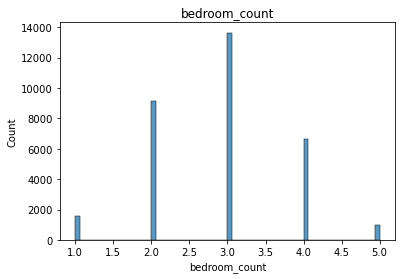

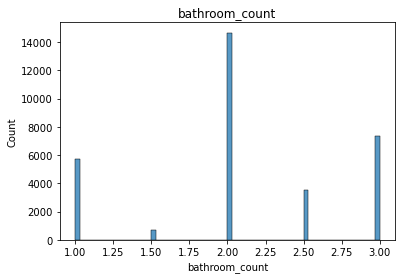

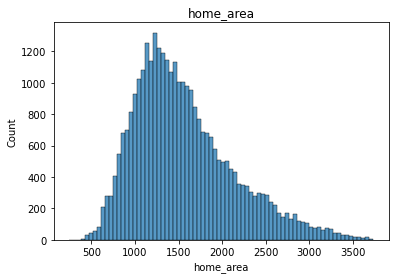

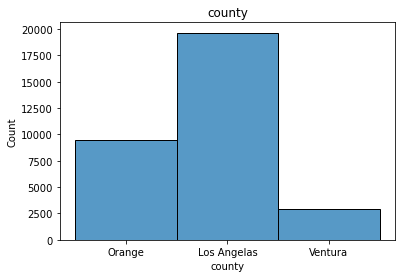

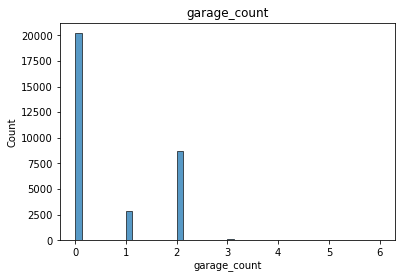

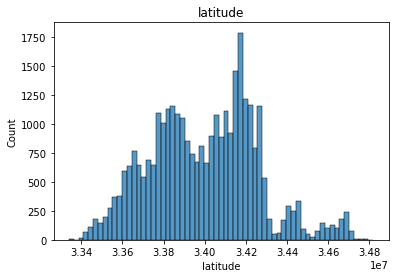

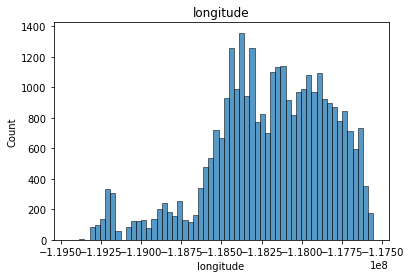

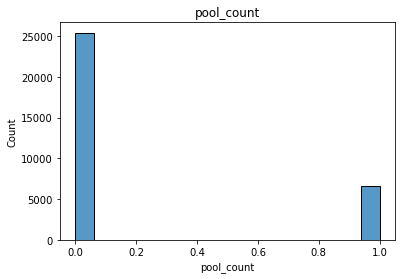

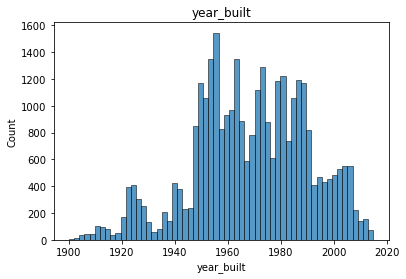

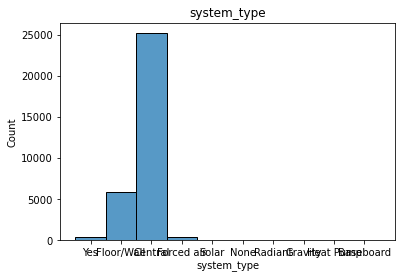

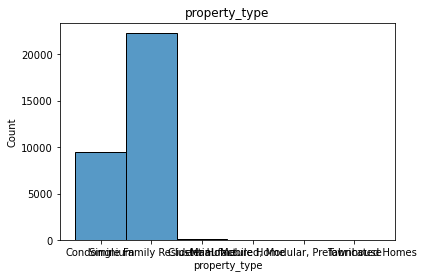

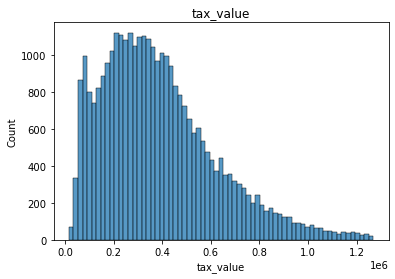

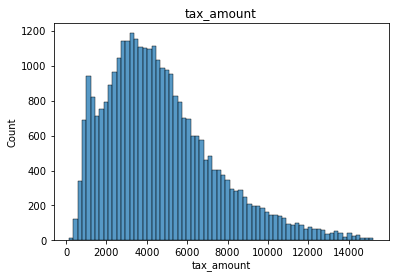

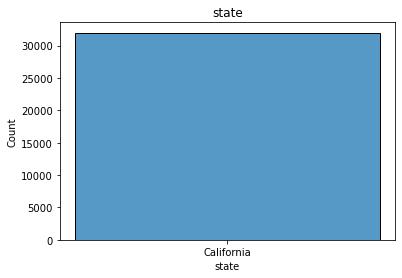

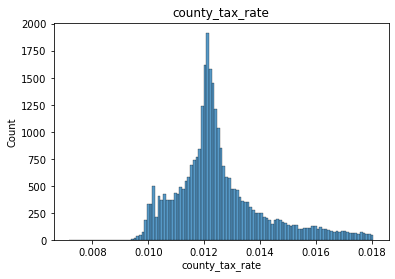

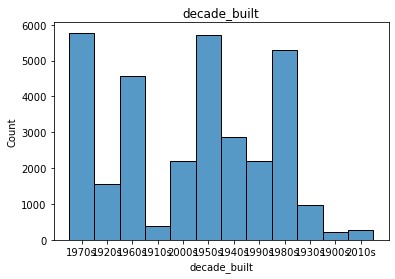

In [42]:
wrangle.get_dists(zillow)

Get the tax rate distributions

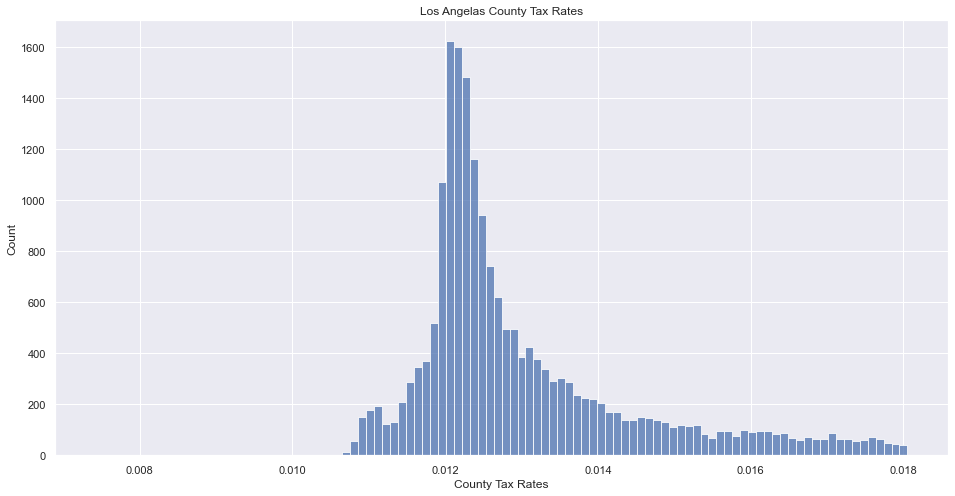

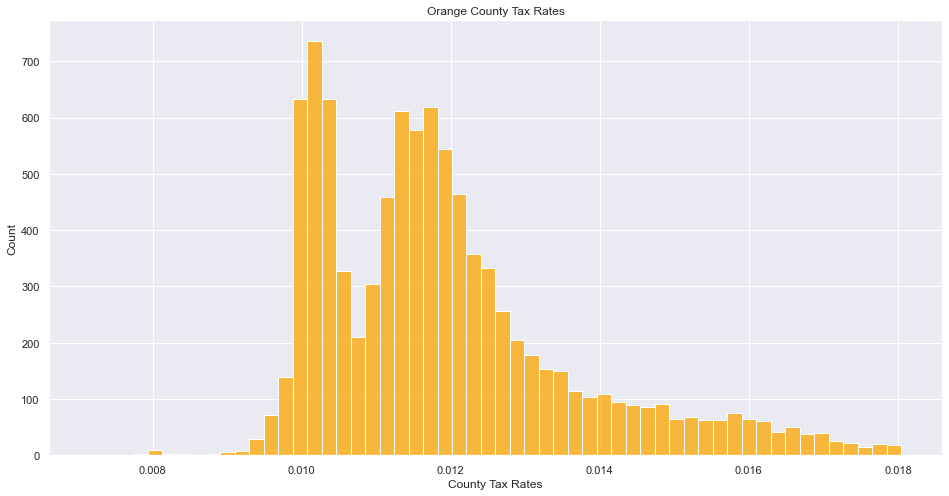

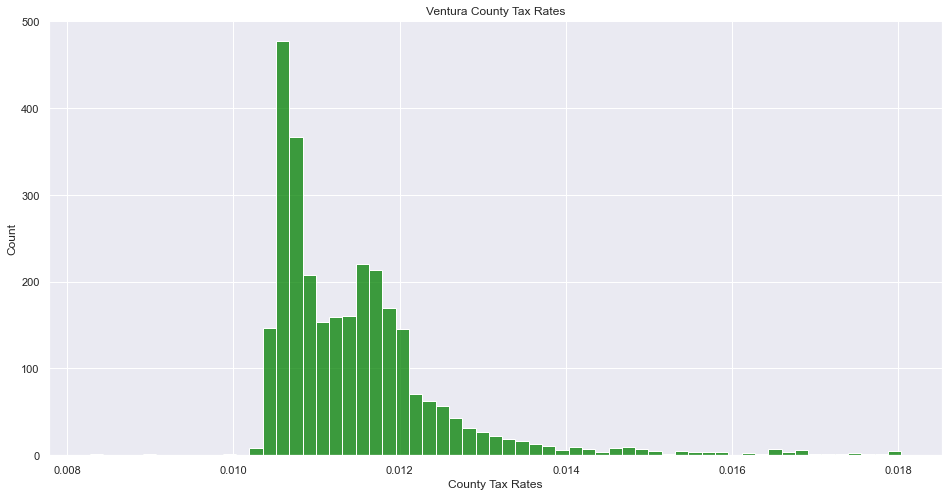

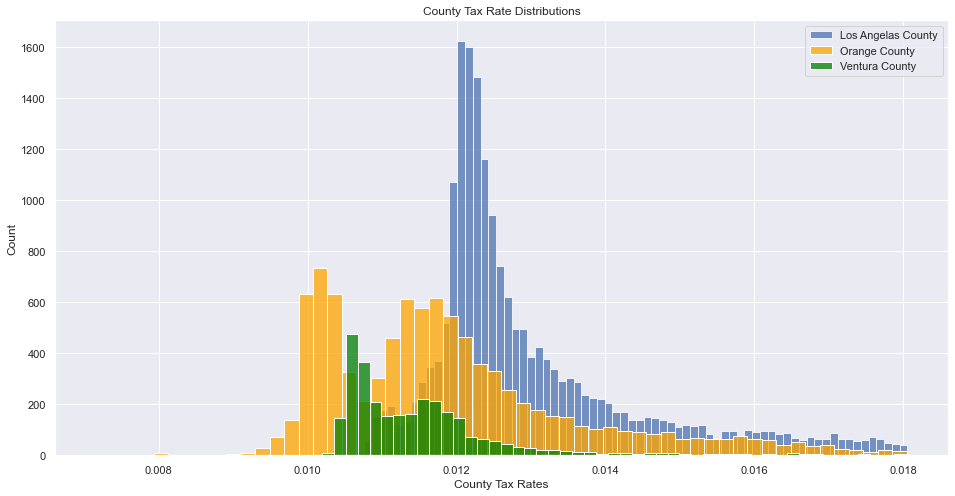

In [43]:
wrangle.get_tax_rate_dists(zillow)

Key Takeaways:
* Despite the added data, the distributions all appear to be the same as before.

### Explore the new Data

In [44]:
#Split data into train, validate, test data sets
train, validate, test = wrangle.train_validate_test_split(zillow)

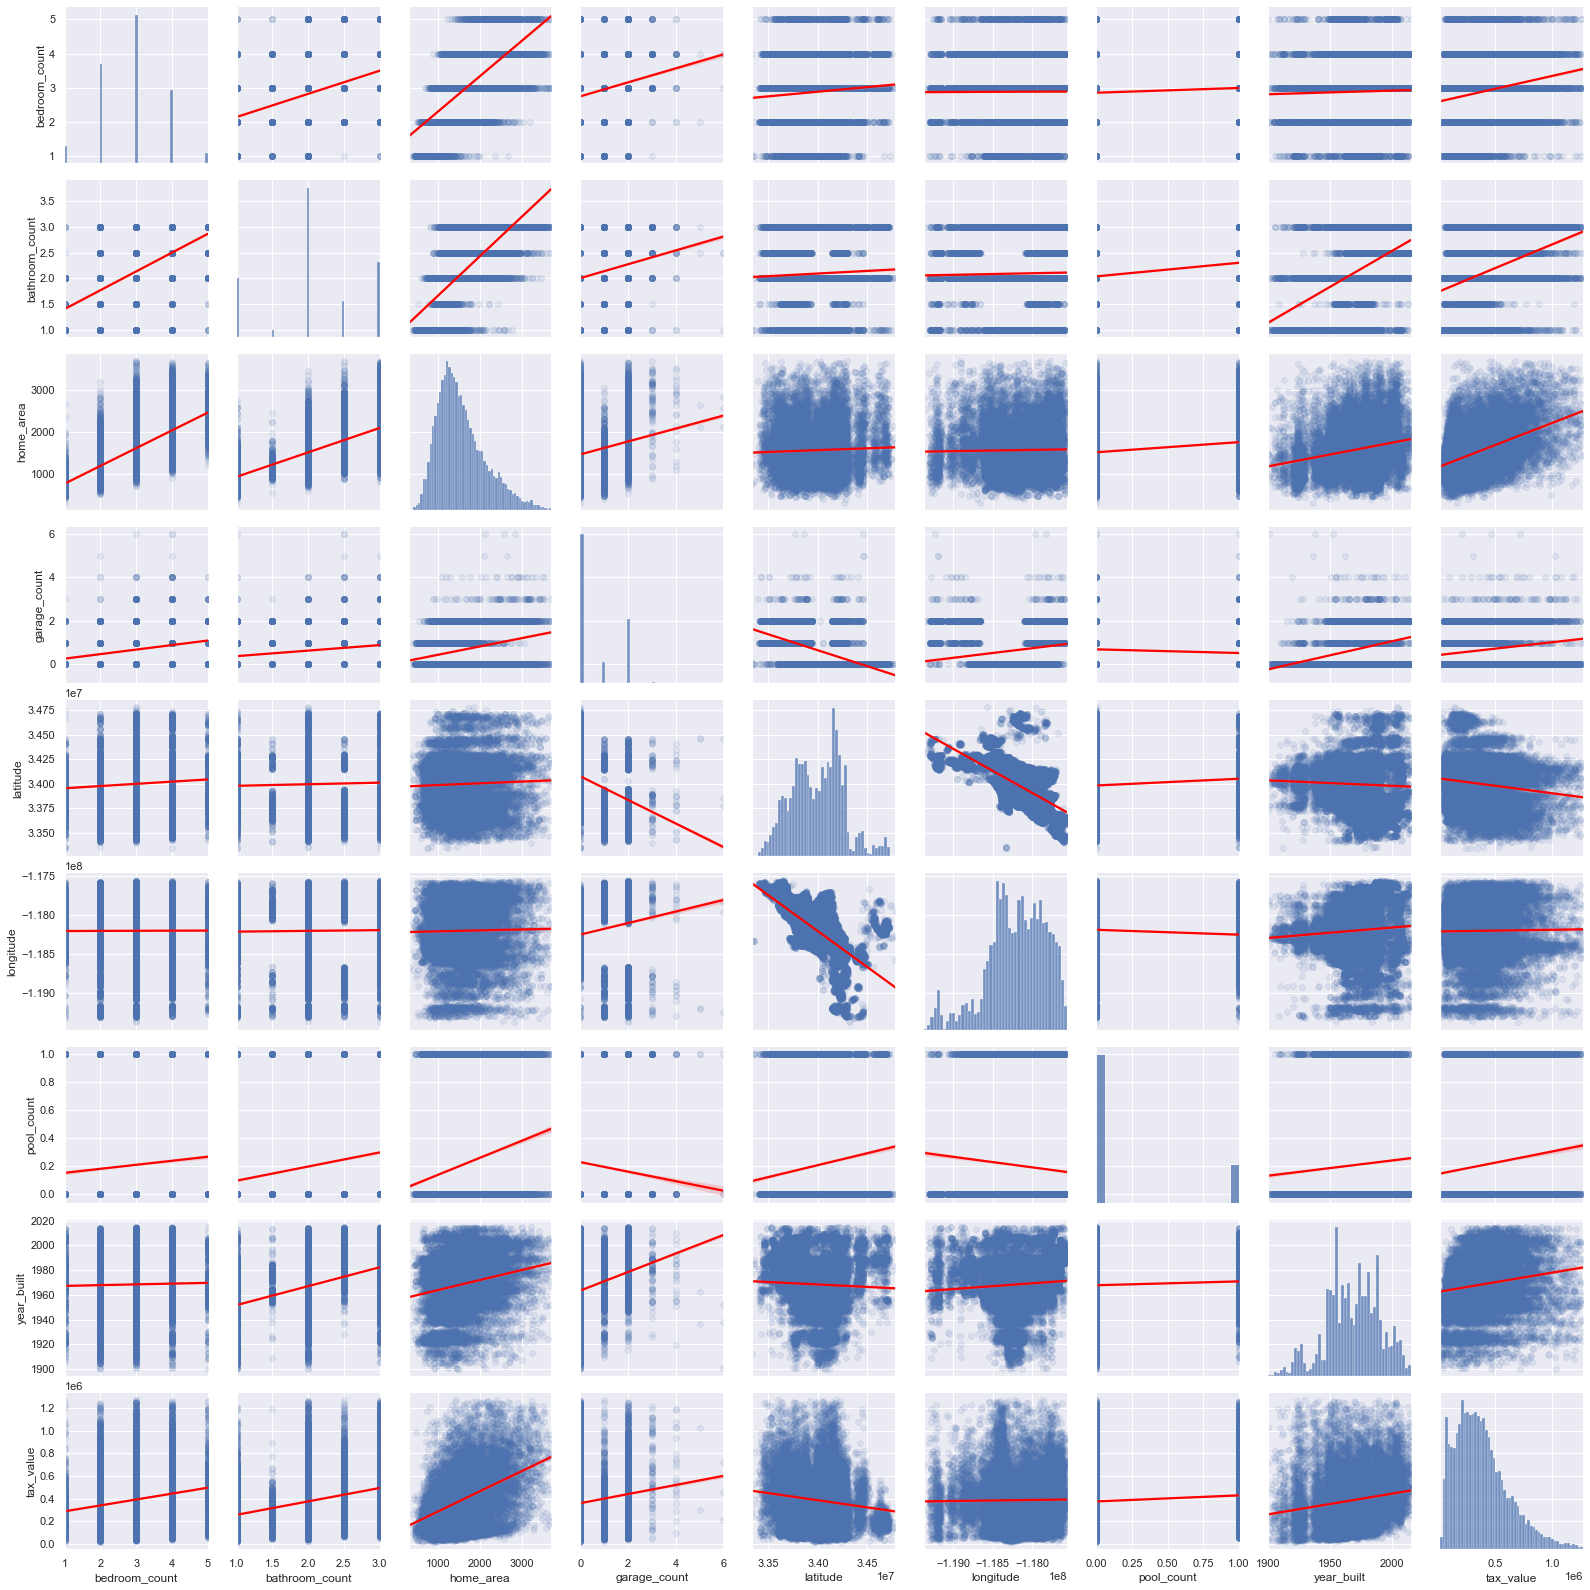

In [45]:
explore.get_pairwise_charts(train)

Key Takeaways:
* Again, home_area has the strongest positive correlation with the target variable, tax_value
* Some others to consider are garage_count, latitude, and year_built
* Latitude seems to have a negative correlation with tax_value, but longitude doesn't appear to have any relationship at all.

In [46]:
num_cols = train.select_dtypes('int').columns.append(train.select_dtypes('float').columns)

cat_cols = train.select_dtypes('object').columns

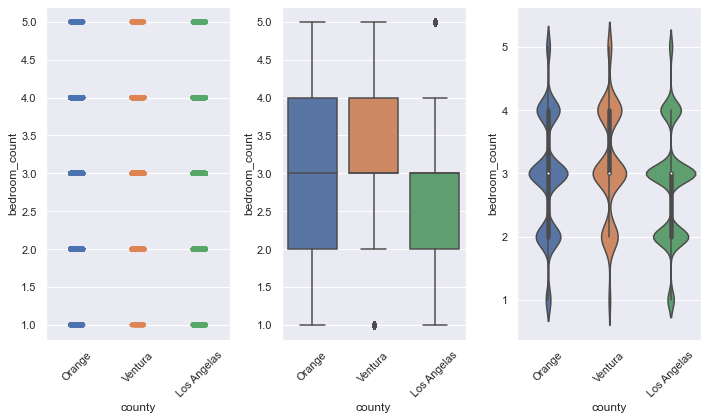

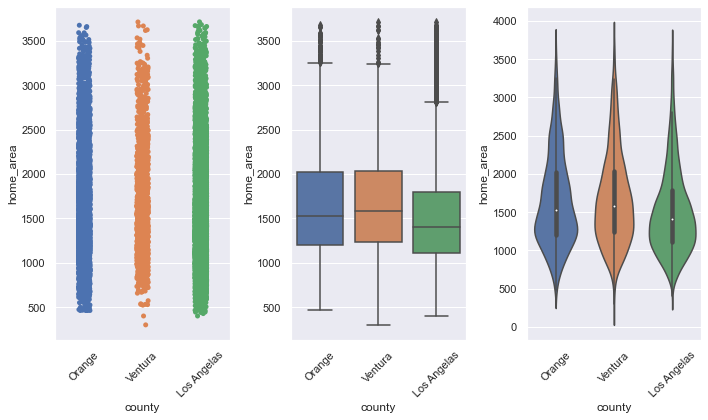

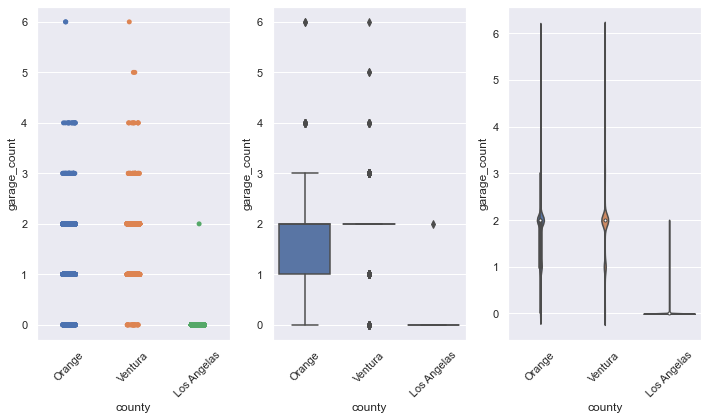

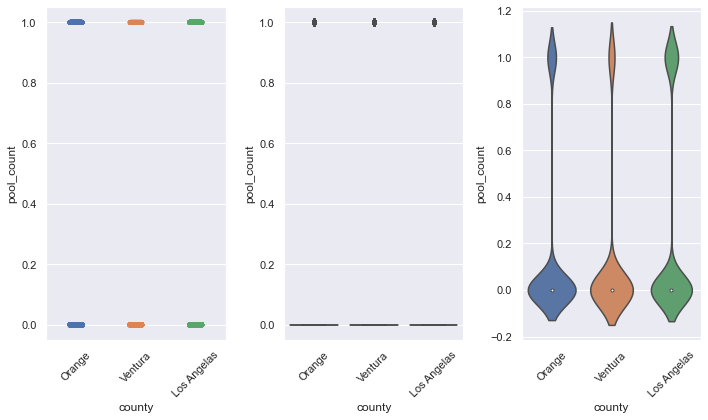

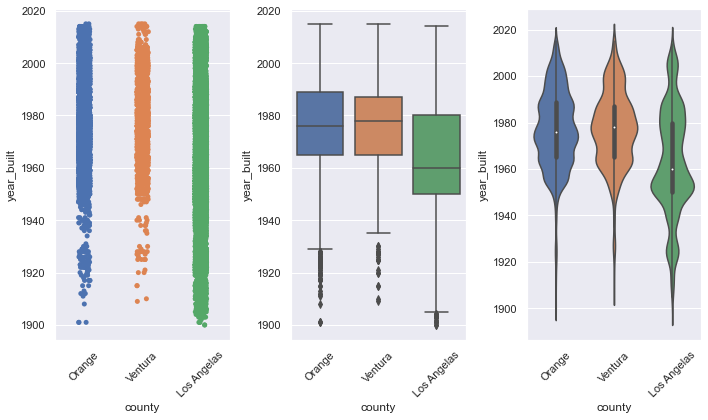

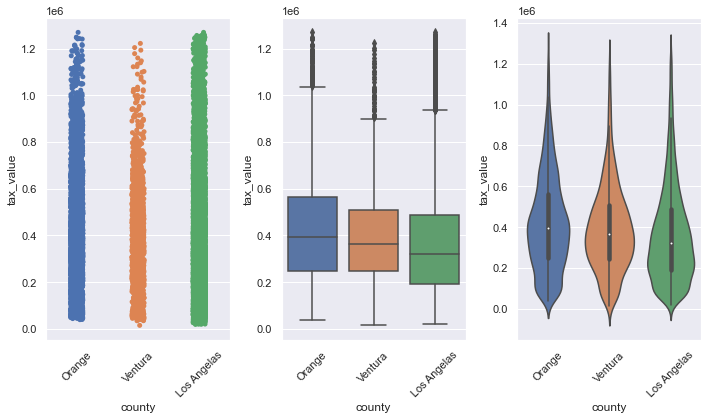

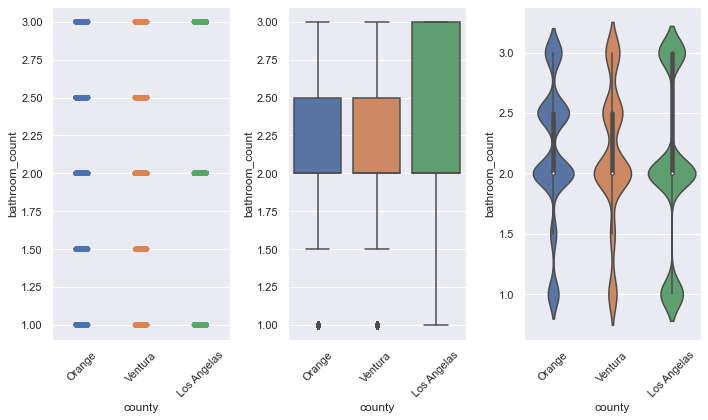

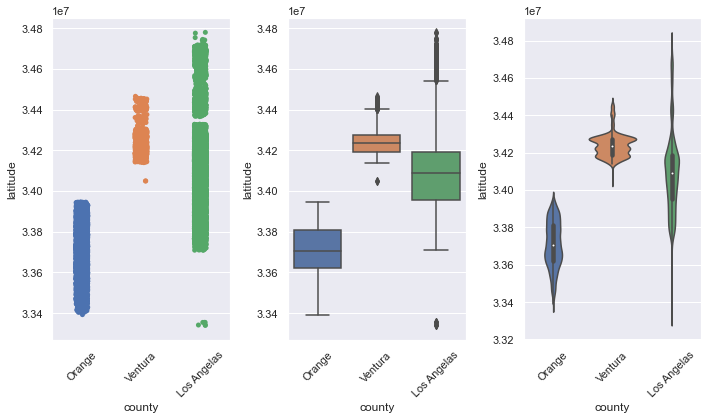

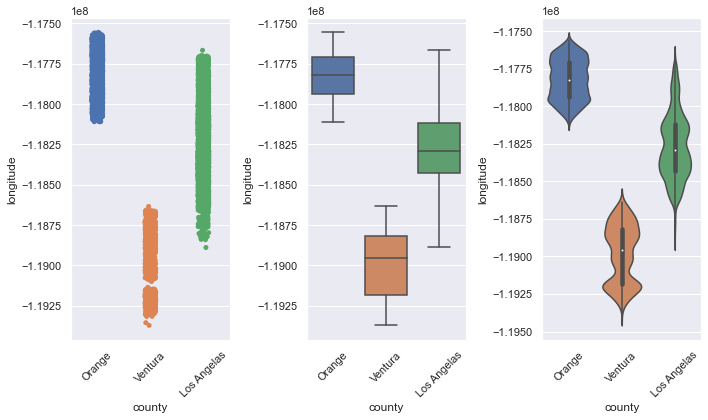

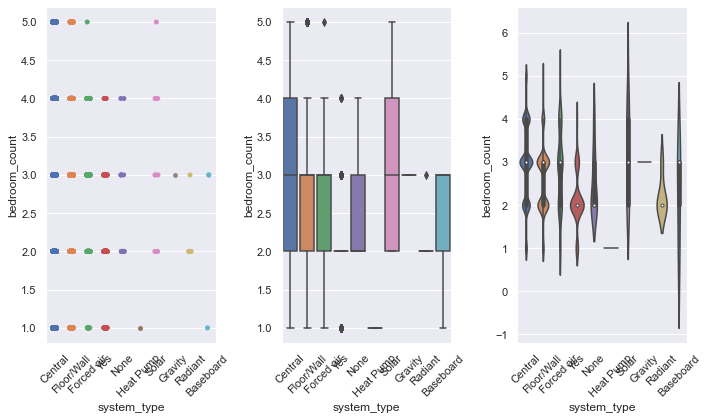

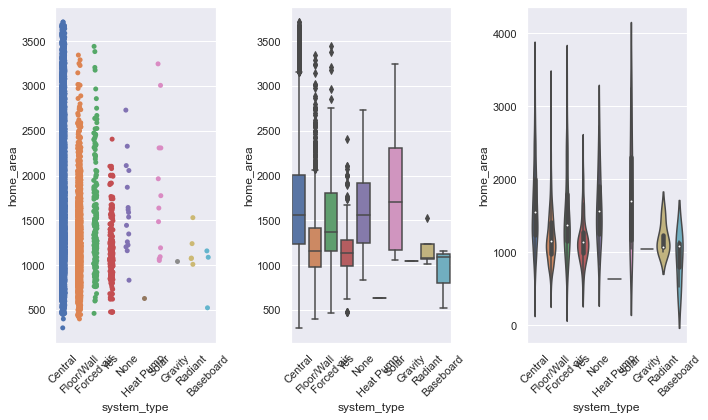

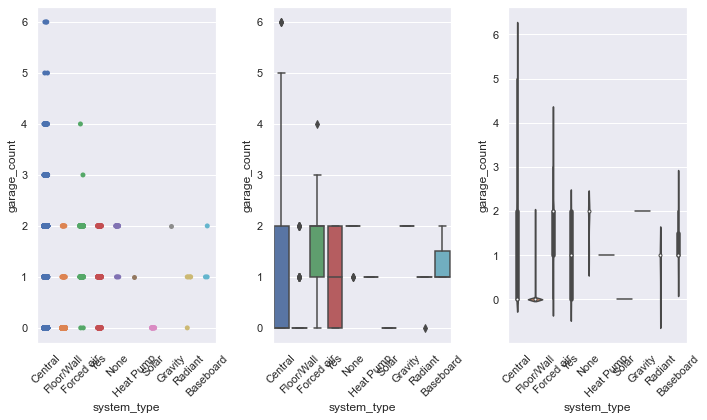

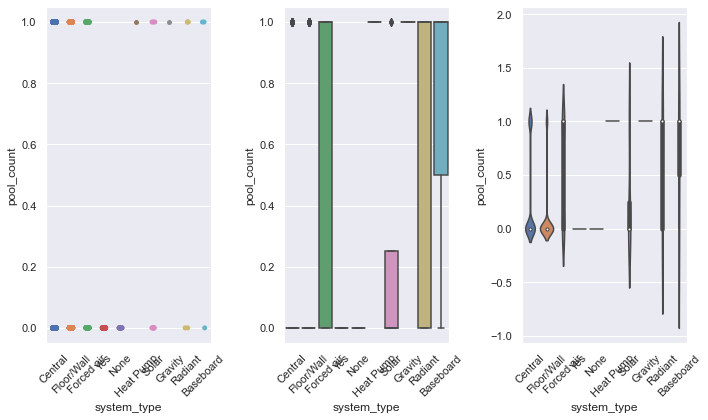

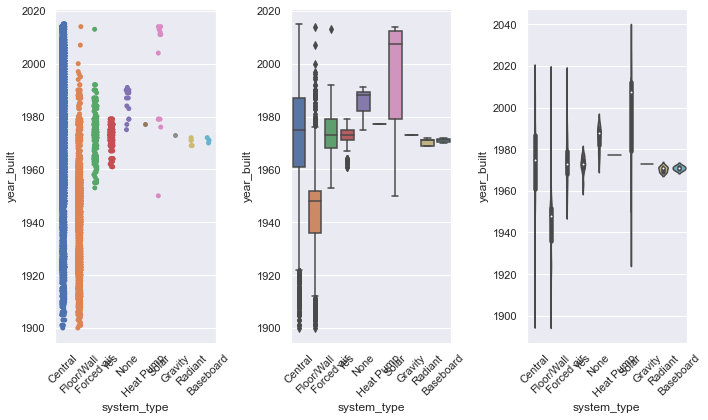

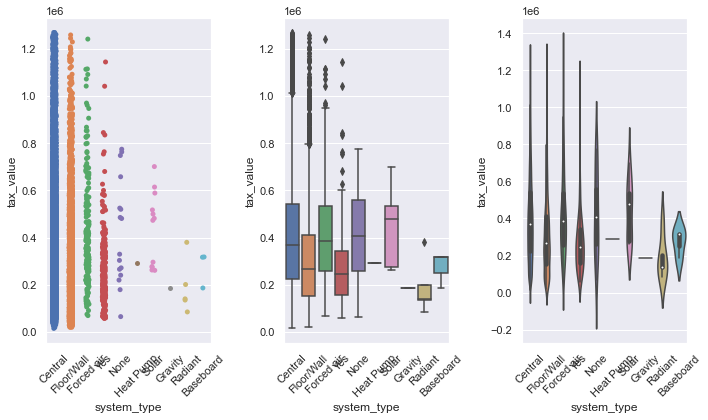

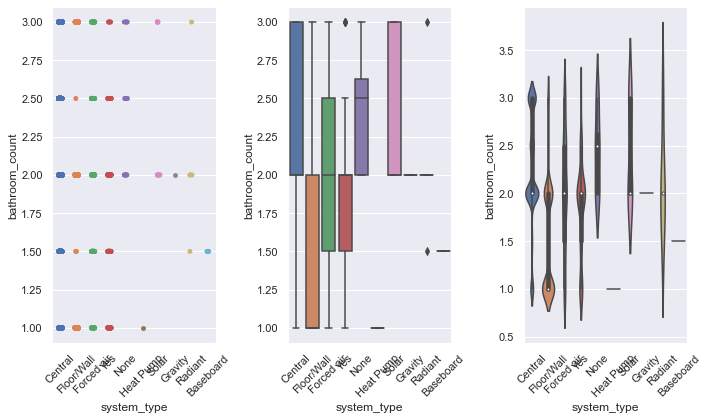

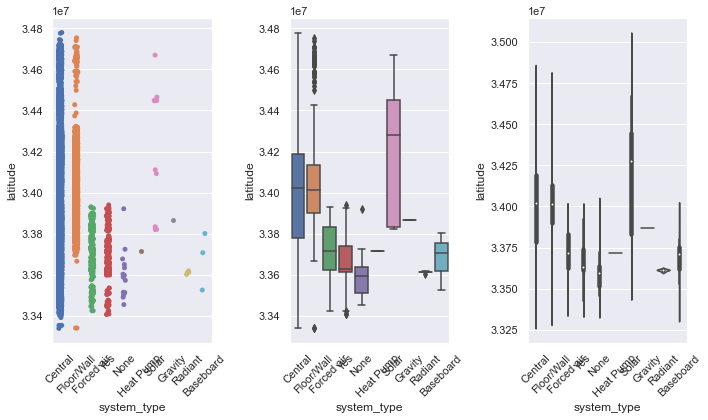

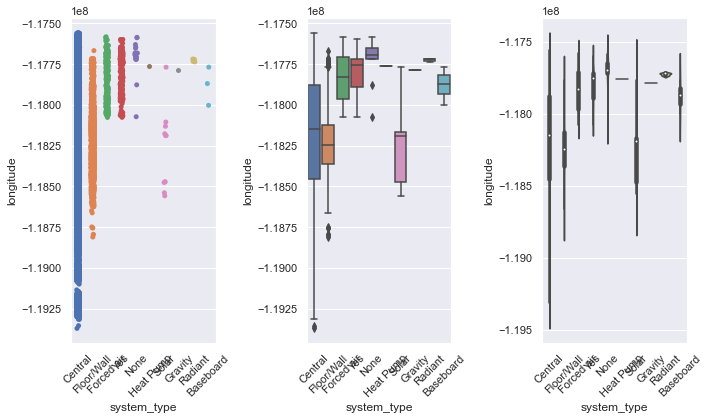

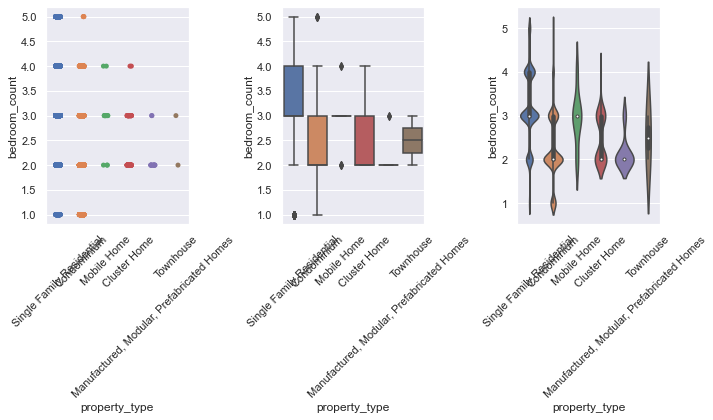

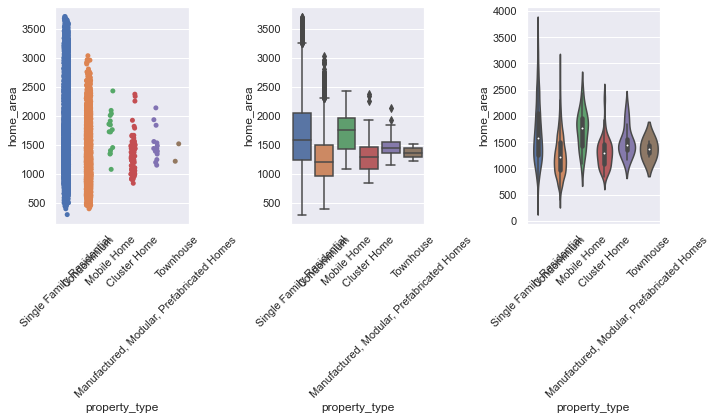

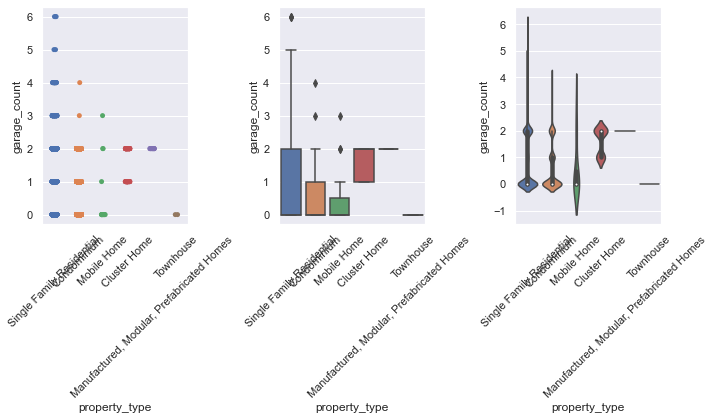

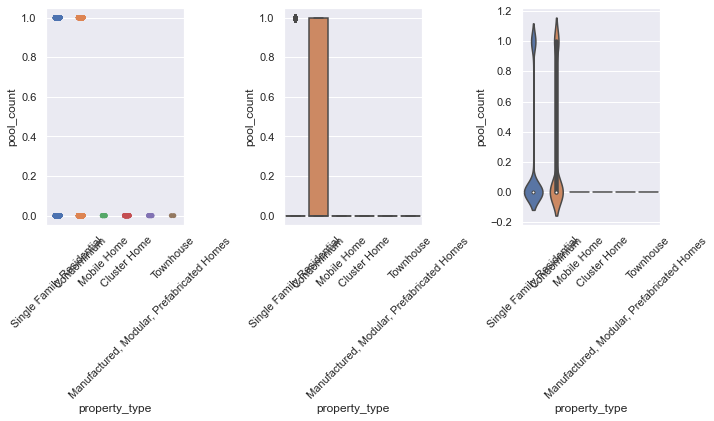

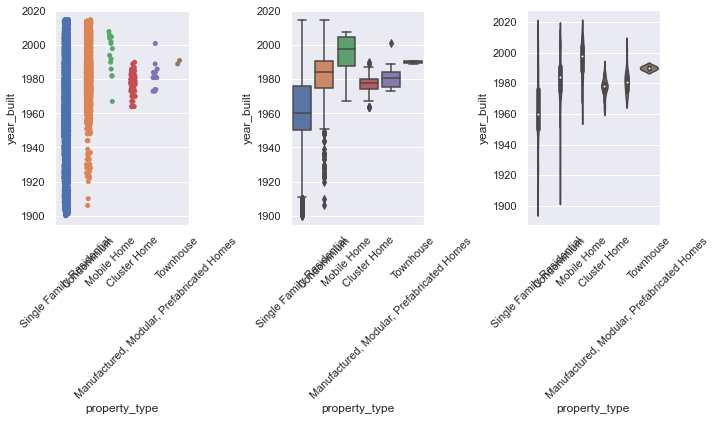

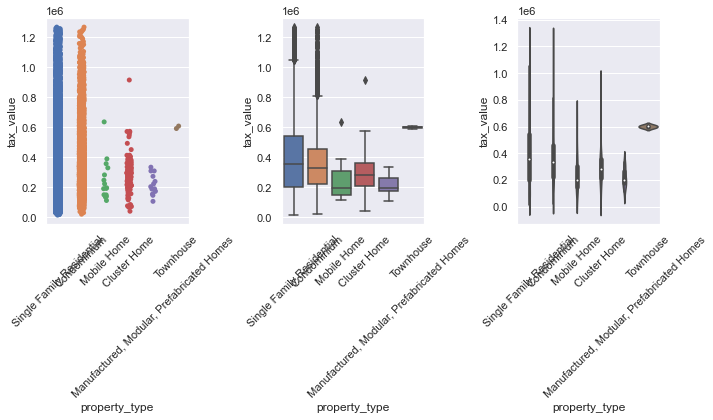

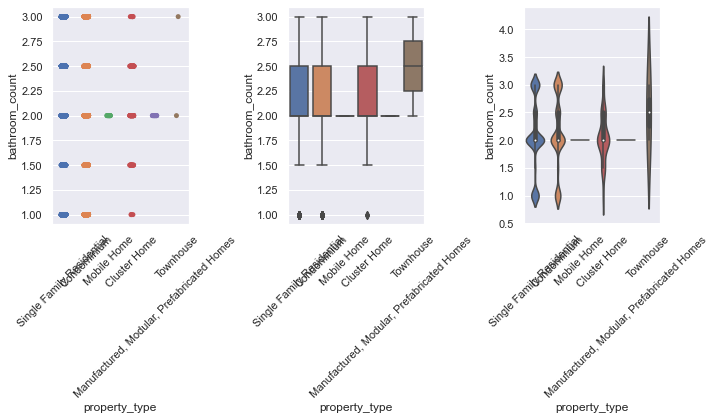

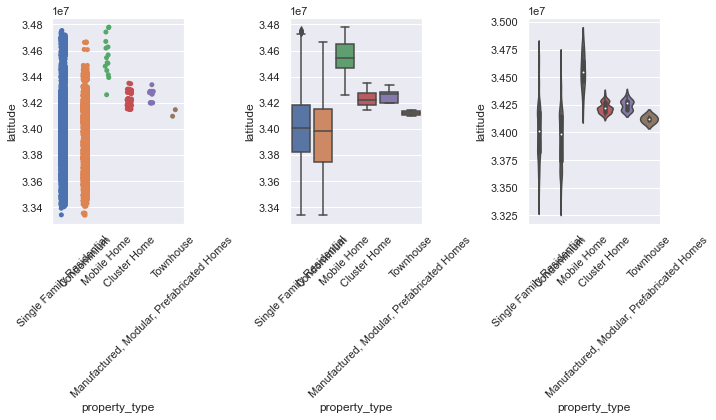

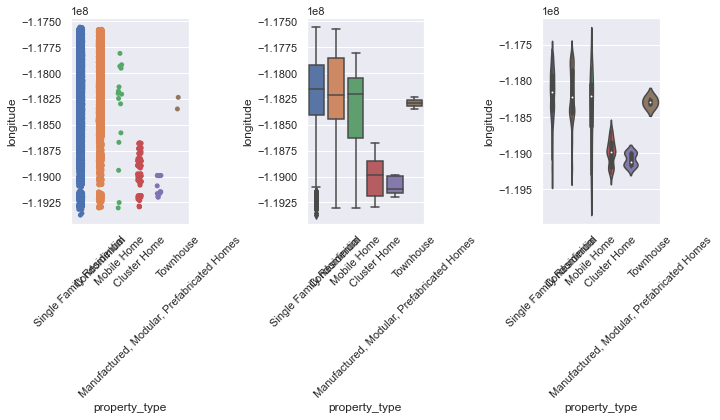

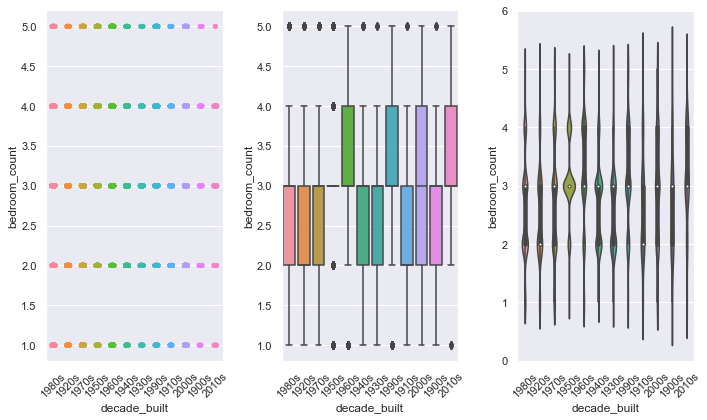

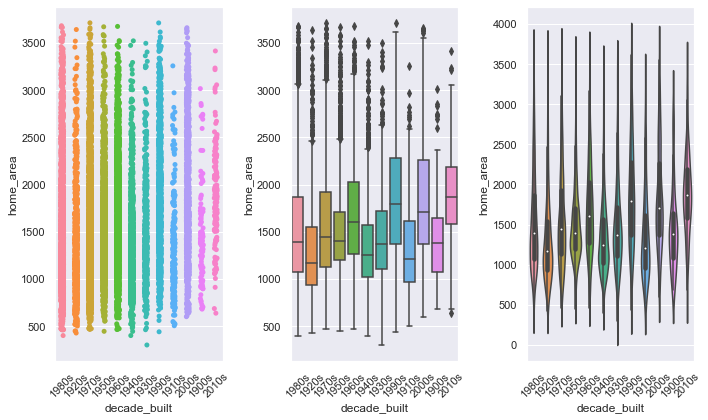

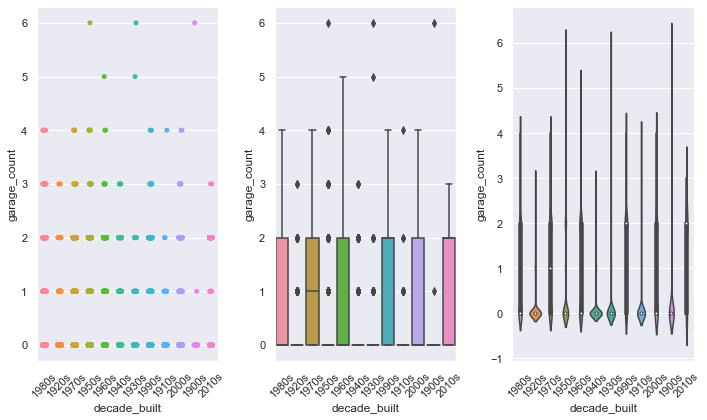

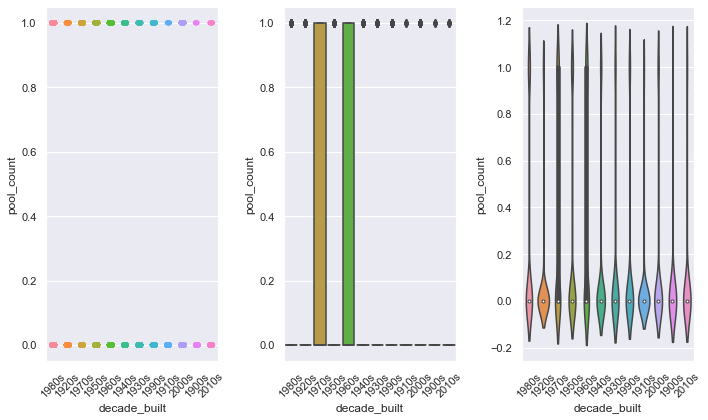

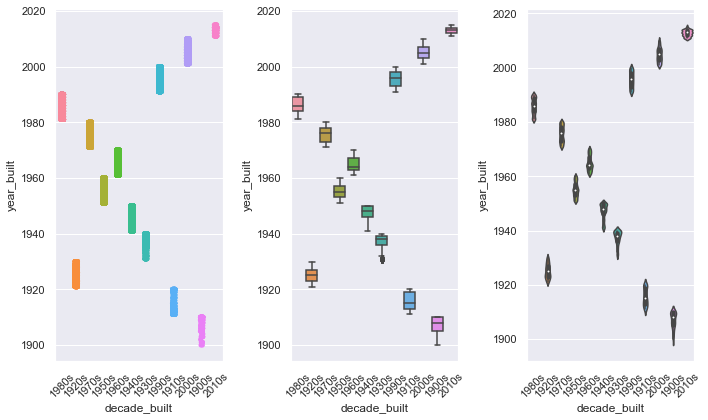

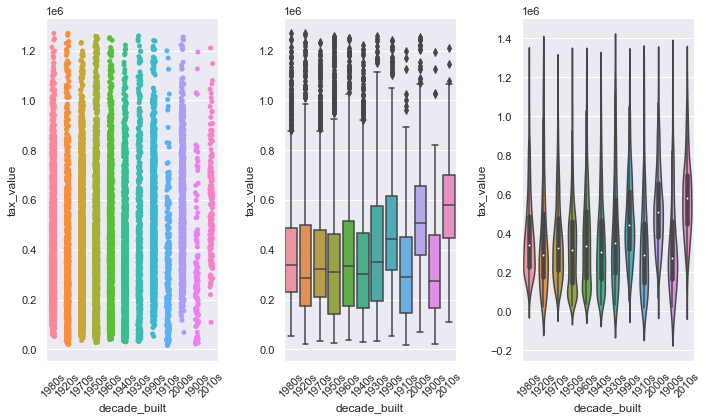

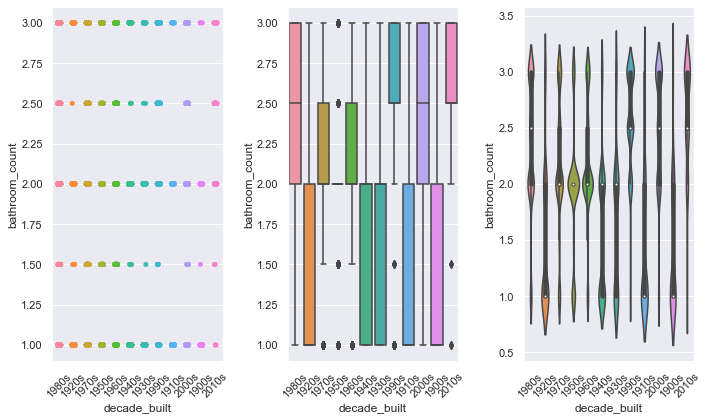

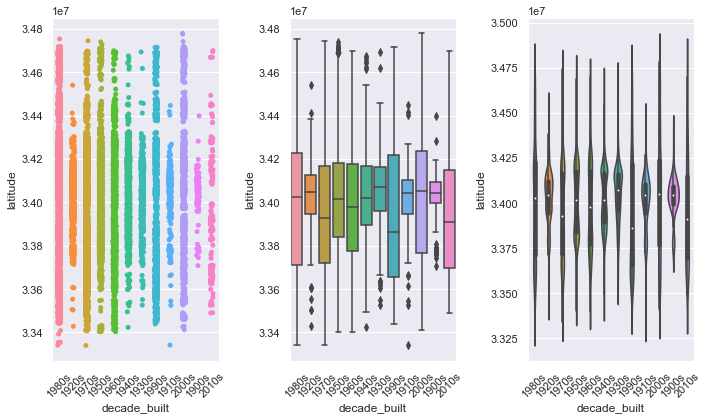

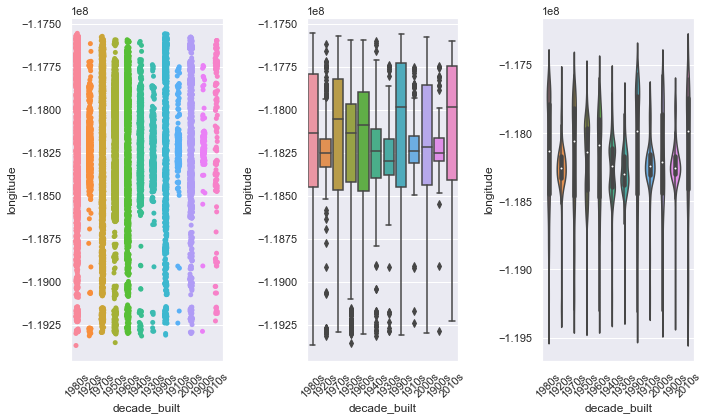

In [47]:
explore.plot_categorical_and_continuous_vars(train, cat_cols, num_cols)

Key Takeaways:
* Orange county seems to have the highest tax_values on average, but I think this is because Orange county also seems to have the largest homes on average.
* Both Orange and Ventura counties seem to have higher bathroom counts on average. Since they also have higher tax_value, maybe this is something worth exploring further.
* Ventura county differs greatly than the other two counties by longitude and latitude. Maybe a ratio of those two variables could be useful.
* County tax rate for Los Angelas county are much higher on average than those for Orange and Ventura counties, but tax_amount is less.
* Hard to get an idea on whether or not property_type has a relationship with tax_value from these graphs. Try a different one graphing tax_value, but give it a hue of property_type.
* Same as above, but for decade_built.

<Figure size 1152x576 with 0 Axes>

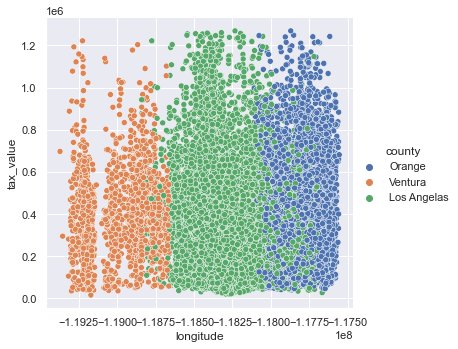

In [48]:
plt.figure(figsize=(16,8))
sns.relplot(x = 'longitude', y = 'tax_value', data = train, hue = 'county')
plt.show()

Is there a relationship between longitude and tax_value?

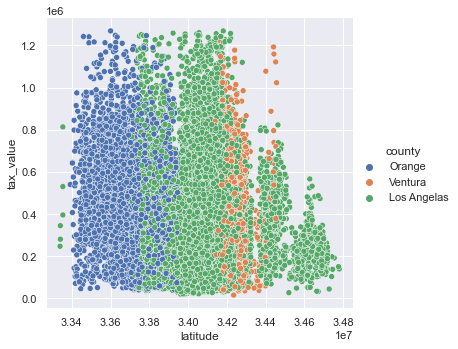

In [49]:
sns.relplot(x = 'latitude', y = 'tax_value', hue = 'county', data = train)
plt.show()

Latitude doesn't seem to be grouped as distinctly as longitude.

In [50]:
#Try making a new variable.
train['lat_long_ratio'] = train.latitude / train.longitude

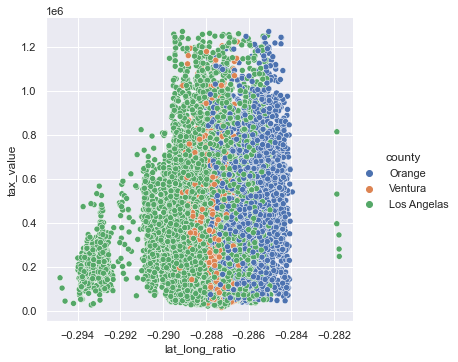

In [51]:
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'county', data = train)
plt.show()

There definitely seems to be a linear relationship here. I think it is worth testing in a hypothesis later.

In [52]:
#Try making a new variable.
train['lat_long_ratio'] = train.longitude - train.latitude

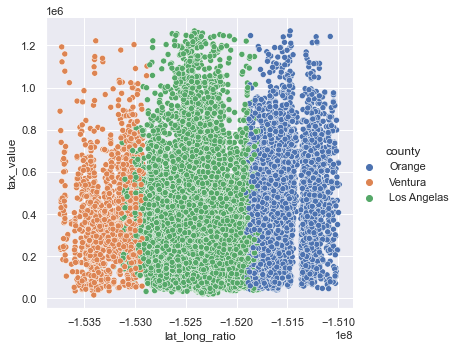

In [53]:
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'county', data = train)
plt.show()

These groupings are very distinctive for county, but don't really seem to have a relationship with tax_value.

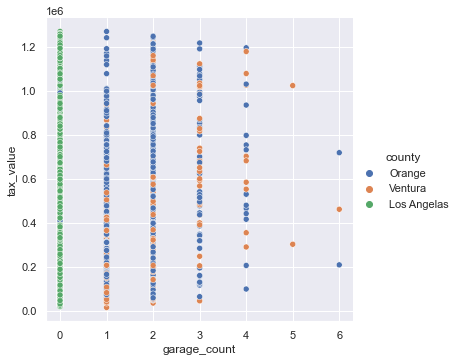

In [54]:
#Move on to garage_count
sns.relplot(x = 'garage_count', y = 'tax_value', hue = 'county', data = train)
plt.show()

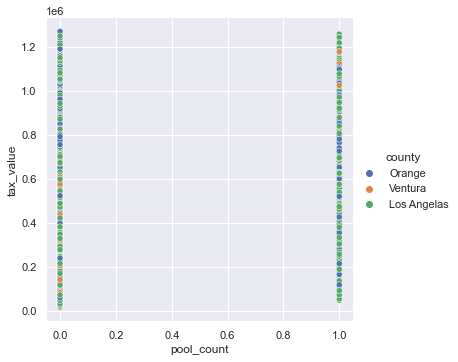

In [55]:
sns.relplot(x = 'pool_count', y = 'tax_value', hue = 'county', data = train)
plt.show()

Garage count and pool count seem to be useless.

In [56]:
#Try changing them to cat vars instead of numerical
train['has_garage'] = train.garage_count > 0
train['has_pool'] = train.pool_count.astype(str)

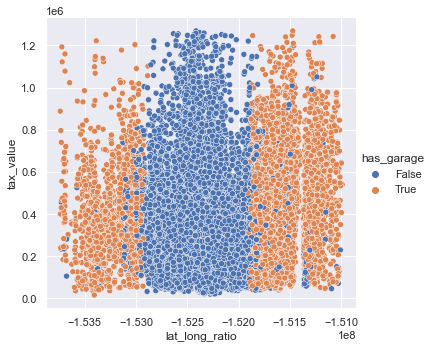

In [57]:
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'has_garage', data = train)
plt.show()

This distribution looks the same as the graph above, and it appears that the Los Angelas County section properties have no garages at all. This may actually be a driver since that county also has lower tax_values overall.

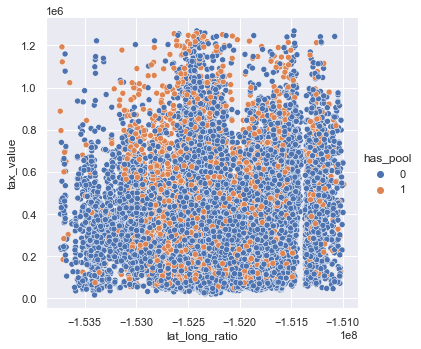

In [58]:
#Now try pool count
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'has_pool', data = train)
plt.show()

There may be a relationship here, but it appears to be pretty weak at best.

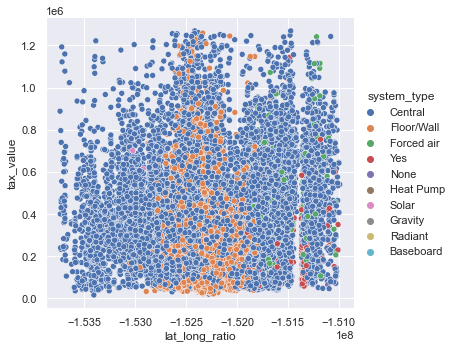

In [59]:
#Try system types
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'system_type', data = train)
plt.show()

Defnitely don't see a relationship here.

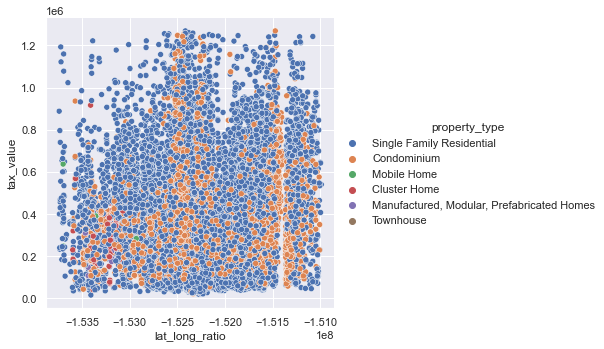

In [60]:
#Try property type
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'property_type', data = train)
plt.show()

In [61]:
#Make a new variable that holds a ratio of bedrooms to baths
train['bed_bath_ratio'] = train.bedroom_count.astype(float) + train.bathroom_count

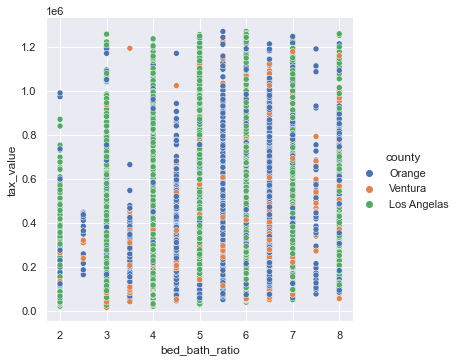

In [62]:
sns.relplot(x = 'bed_bath_ratio', y = 'tax_value', hue = 'county', data = train)
plt.show()

There may be a relationship here, but I'm not sure.

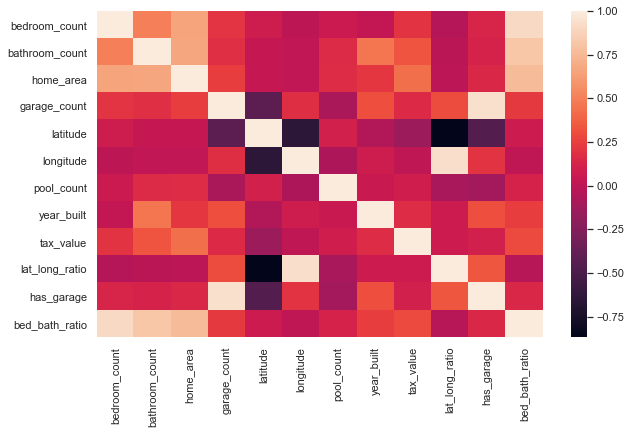

In [63]:
sns.heatmap(train.corr())
plt.show()

Again, there does not seem to be a relationship. Moving on.

In [64]:
import scipy.stats as stats

### Hypothesis Testing

__Hypothesis 1__

$H_0$: The average home_area of Orange County properties is <= The average home_area of Los Angelas and Ventura County properties.
    
$H_a$: The average home_area of Orange County properties is > The average home_area of Los Angelas and Ventura County properties.

In [65]:
alpha = 0.05

In [66]:
orange_county = train[train.county == 'Orange']
other_counties = train[train.county != 'Orange']

In [67]:
orange_county.tax_value.mean()

421688.5716991855

In [68]:
other_counties.tax_value.mean()

370999.3428548821

In [69]:
t, p = stats.ttest_ind(orange_county.home_area, other_counties.home_area)
t, p

(12.233869582730449, 2.8082080100175327e-34)

In [70]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


__Hypothesis 2__

$H_0$: The average tax_value of Orange County properties is <= The average tax_value of Los Angelas and Ventura County properties.
    
$H_a$: The average tax_value of Orange County properties is > The average tax_value of Los Angelas and Ventura County properties.

In [71]:
alpha = 0.05

In [72]:
t, p = stats.ttest_ind(orange_county.tax_value, other_counties.tax_value)
t,p

(13.178994238904375, 1.769792358591309e-39)

In [73]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


__Hypothesis 3__

$H_0$: lat_long_ratio is not linearly correlated with tax_value.
    
$H_a$: lat_long_ratio is linearly correlated with tax_value.

In [74]:
alpha = 0.05

In [75]:
corr, p = stats.pearsonr(train.lat_long_ratio, train.tax_value)
corr, p

(0.07158325848140328, 8.52510615781465e-22)

In [76]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


__Hypothesis 4__

$H_0$: The average tax_value of Orange County properties is <= The average tax_value of Ventura County properties.
    
$H_a$: The average tax_value of Orange County properties is > The average tax_value of  Ventura County properties.

In [77]:
alpha = 0.05

In [78]:
ventura_county = train[train.county == 'Ventura']

In [79]:
t, p = stats.ttest_ind(orange_county.tax_value, ventura_county.tax_value)
t, p

(4.432045595852302, 9.478687436958835e-06)

In [80]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


__Hypothesis 5__

$H_0$: The average tax_value of Orange County properties is <= The average tax_value of Los Angelas County properties.
    
$H_a$: The average tax_value of Orange County properties is > The average tax_value of Los Angelas County properties.

In [81]:
alpha = 0.05

In [82]:
la_county = train[train.county == 'Los Angelas']

In [83]:
t, p = stats.ttest_ind(orange_county.tax_value, la_county.tax_value)
t, p

(13.600284628330304, 6.754477149312193e-42)

In [84]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


__Hypothesis 6__

$H_0$: The average tax_value of Ventura County properties is <= The average tax_value of Los Angelas County properties.
    
$H_a$: The average tax_value of Ventura County properties is > The average tax_value of Los Angelas County properties.

In [85]:
alpha = 0.05

In [86]:
t, p = stats.ttest_ind(ventura_county.tax_value, la_county.tax_value)
t, p

(4.0209682107652895, 5.829620707007245e-05)

In [87]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


Key Takeaways:
* Since my statistical testing has shown that the average tax_values of each county is significantly different than each other, I think that 'county' would be a good feature for my model.
* I also think that lat_long_ratio would be a good feature.


### Begin Modeling with New Features

In [88]:
#First drop the columns, you don't plan on using.
#Also, add lat_long_ratio to validate and test sets and correct it in the train data set
train.lat_long_ratio = train.latitude / train.longitude
validate['lat_long_ratio'] = validate.latitude / validate.longitude
test['lat_long_ratio'] = test.latitude / test.longitude

validate['has_pool'] = (validate.pool_count > 0).astype(int)
test['has_pool'] = (test.pool_count > 0).astype(int)

In [89]:
train = train[['bedroom_count', 'bathroom_count', 'home_area', 'county', 'tax_value', 'latitude', 'longitude', 'year_built']].copy()
validate = validate[['bedroom_count', 'bathroom_count', 'home_area', 'county', 'tax_value', 'latitude', 'longitude', 'year_built']].copy()
test = test[['bedroom_count', 'bathroom_count', 'home_area', 'county', 'tax_value', 'latitude', 'longitude', 'year_built']].copy()
train.head()

bedroom_count  bathroom_count  home_area       county  tax_value  \
1780               3             2.5       1426       Orange     692000   
18658              2             1.0        784      Ventura     244246   
26735              4             2.5       2749       Orange     431713   
26758              3             2.0       1878       Orange     463389   
2843               4             2.0       1440  Los Angelas     447100   

         latitude    longitude  year_built  
1780   33525042.0 -117692408.0        1987  
18658  34286521.0 -119303286.0        1927  
26735  33566860.0 -117663901.0        1972  
26758  33600065.0 -117873592.0        1956  
2843   34425874.0 -118488233.0        1966

In [90]:
#Create dummy variables
train_dummies = pd.get_dummies(train[['county']], dummy_na=False, drop_first=True)
train = pd.concat([train, train_dummies], axis = 1).drop(columns = ['county'])

validate_dummies = pd.get_dummies(validate[['county']], dummy_na=False, drop_first=True)
validate = pd.concat([validate, validate_dummies], axis = 1).drop(columns = ['county'])

test_dummies = pd.get_dummies(test[['county']], dummy_na=False, drop_first=True)
test = pd.concat([test, test_dummies], axis = 1).drop(columns = ['county'])

In [91]:
#Split into X and y groups
X_train, y_train = train.drop('tax_value', axis = 1), train.tax_value
X_validate, y_validate = validate.drop('tax_value', axis = 1), validate.tax_value
X_test, y_test = test.drop('tax_value', axis = 1), test.tax_value

In [92]:
X_train_scaled, X_validate_scaled, X_test_scaled = model.scale_data(X_train, X_validate, X_test)

In [93]:
#Assign the scaled columns as new columns in each set
cols_to_scale = ['bedroom_count', 'bathroom_count', 'home_area', 'latitude', 'longitude', 'year_built', 'county_Orange', 'county_Ventura']
cols_scaled = ['bedroom_count_scaled', 'bathroom_count_scaled', 'home_area_scaled', 'latitude_scaled', 'longitude_scaled', 'year_built_scaled', 'county_Orange_scaled', 'county_Ventura_scaled']

train[cols_scaled] = X_train_scaled
validate[cols_scaled] = X_validate_scaled
test[cols_scaled] = X_test_scaled

In [94]:
#model.compare_dists(train, cols_to_scale, cols_scaled)

Distributions appear to be the same, so we can move forward.

In [95]:
#Create the metric data frame to hold the evaluation metrics for each of the models
metric_df = pd.DataFrame()

In [97]:
#Create the baseline
y_train, y_validate, y_test, metric_df = model.get_baseline(y_train, y_validate, y_test, metric_df)

RMSE using Mean
Train/In-Sample:  235823.26 
Validate/Out-of-Sample:  233447.73 



In [98]:
#Create OLS model
lm, metric_df = model.get_ols_model(X_train_scaled, X_validate_scaled, y_train, y_validate, metric_df)

RMSE using OLS
Train/In-Sample:  204015.51 
Validate/Out-of-Sample:  200936.12


In [99]:
#Create LassoLars models
lars_models, metric_df = model.get_lars_models(X_train_scaled, X_validate_scaled, y_train, y_validate, metric_df)


RMSE using LassoLars, alpha = 1
Train/In-Sample:  204016.49 
Validate/Out-of-Sample:  200930.59

RMSE using LassoLars, alpha = 2
Train/In-Sample:  204019.41 
Validate/Out-of-Sample:  200927.07

RMSE using LassoLars, alpha = 3
Train/In-Sample:  204024.29 
Validate/Out-of-Sample:  200925.56

RMSE using LassoLars, alpha = 4
Train/In-Sample:  204031.11 
Validate/Out-of-Sample:  200926.06

RMSE using LassoLars, alpha = 5
Train/In-Sample:  204039.88 
Validate/Out-of-Sample:  200928.57

RMSE using LassoLars, alpha = 6
Train/In-Sample:  204050.61 
Validate/Out-of-Sample:  200933.08

RMSE using LassoLars, alpha = 7
Train/In-Sample:  204063.28 
Validate/Out-of-Sample:  200939.61

RMSE using LassoLars, alpha = 8
Train/In-Sample:  204077.9 
Validate/Out-of-Sample:  200948.14

RMSE using LassoLars, alpha = 9
Train/In-Sample:  204094.46 
Validate/Out-of-Sample:  200958.68

RMSE using LassoLars, alpha = 10
Train/In-Sample:  204112.98 
Validate/Out-of-Sample:  200971.23

RMSE using LassoLars, alpha =

In [100]:
#Create GLM model, TweedieRegressor
glm, metric_df = model.get_glm_model(X_train_scaled, X_validate_scaled, y_train, y_validate, metric_df)


RMSE for Power = 0, Alpha = 1

Train/In-Sample:  213621.6 
Validate/Out-of-Sample:  210879.97

RMSE for Power = 0, Alpha = 2

Train/In-Sample:  218063.34 
Validate/Out-of-Sample:  215425.69

RMSE for Power = 0, Alpha = 3

Train/In-Sample:  220911.13 
Validate/Out-of-Sample:  218328.67

RMSE for Power = 0, Alpha = 4

Train/In-Sample:  222956.4 
Validate/Out-of-Sample:  220409.18

RMSE for Power = 0, Alpha = 5

Train/In-Sample:  224506.47 
Validate/Out-of-Sample:  221983.97

RMSE for Power = 0, Alpha = 6

Train/In-Sample:  225723.62 
Validate/Out-of-Sample:  223219.5

RMSE for Power = 0, Alpha = 7

Train/In-Sample:  226705.0 
Validate/Out-of-Sample:  224215.13

RMSE for Power = 0, Alpha = 8

Train/In-Sample:  227513.09 
Validate/Out-of-Sample:  225034.58

RMSE for Power = 0, Alpha = 9

Train/In-Sample:  228190.0 
Validate/Out-of-Sample:  225720.79

RMSE for Power = 0, Alpha = 10

Train/In-Sample:  228765.22 
Validate/Out-of-Sample:  226303.77

RMSE for Power = 1, Alpha = 1

Train/In-Sam

In [101]:
#Create polynomial features and model
X_test_degree2, lm2, metric_df = model.get_polynomial_model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, metric_df)

RMSE for Polynomial Features, degree = 2
Train/In-Sample:  197059.96 
Validate/Out-of-Sample:  194265.22
RMSE for Polynomial Features, degree = 3
Train/In-Sample:  192789.3 
Validate/Out-of-Sample:  189613.63
RMSE for Polynomial Features, degree = 4
Train/In-Sample:  188314.65 
Validate/Out-of-Sample:  189066.54
RMSE for Polynomial Features, degree = 5
Train/In-Sample:  182216.02 
Validate/Out-of-Sample:  189952.66


In [102]:
metric_df

model  RMSE_validate  r^2_validate
0          validate_baseline_mean  233447.732924      0.000000
1                    validate_ols  200936.123238      0.259277
2           validate_lars_alpha_1  200930.593984      0.259316
3           validate_lars_alpha_2  200927.073626      0.259340
4           validate_lars_alpha_3  200925.562270      0.259349
5           validate_lars_alpha_4  200926.059962      0.259344
6           validate_lars_alpha_5  200928.566685      0.259323
7           validate_lars_alpha_6  200933.082366      0.259288
8           validate_lars_alpha_7  200939.606869      0.259238
9           validate_lars_alpha_8  200948.139997      0.259174
10          validate_lars_alpha_9  200958.681496      0.259094
11         validate_lars_alpha_10  200971.231049      0.259000
12         validate_lars_alpha_11  200985.788279      0.258891
13         validate_lars_alpha_12  201002.352752      0.258767
14         validate_lars_alpha_13  201020.923970      0.258628
15         validate_lars_alpha_14  201041.501378      0.258475
16         validate_lars_alpha_15  201064.084359      0.258306
17         validate_lars_alpha_16  201088.672237      0.258123
18         validate_lars_alpha_17  201115.264279      0.257925
19         validate_lars_alpha_18  201143.859687      0.257713
20         validate_lars_alpha_19  201174.457610      0.257485
21         validate_lars_alpha_20  201207.057131      0.257243
22   validate_glm_power_0_alpha_1  210879.965186      0.184016
23   validate_glm_power_0_alpha_2  215425.685933      0.148449
24   validate_glm_power_0_alpha_3  218328.667263      0.125341
25   validate_glm_power_0_alpha_4  220409.179348      0.108590
26   validate_glm_power_0_alpha_5  221983.969354      0.095805
27   validate_glm_power_0_alpha_6  223219.495495      0.085711
28   validate_glm_power_0_alpha_7  224215.126249      0.077537
29   validate_glm_power_0_alpha_8  225034.584840      0.070781
30   validate_glm_power_0_alpha_9  225720.793515      0.065105
31  validate_glm_power_0_alpha_10  226303.766519      0.060270
32   validate_glm_power_1_alpha_1  201443.650960      0.255525
33   validate_glm_power_1_alpha_2  201443.633710      0.255525
34   validate_glm_power_1_alpha_3  201443.616463      0.255525
35   validate_glm_power_1_alpha_4  201443.599218      0.255525
36   validate_glm_power_1_alpha_5  201443.581976      0.255526
37   validate_glm_power_1_alpha_6  201443.564737      0.255526
38   validate_glm_power_1_alpha_7  201443.547501      0.255526
39   validate_glm_power_1_alpha_8  201443.530267      0.255526
40   validate_glm_power_1_alpha_9  201443.513036      0.255526
41  validate_glm_power_1_alpha_10  201443.495807      0.255526
42   validate_glm_power_2_alpha_1  210849.548762      0.185455
43   validate_glm_power_2_alpha_2  215568.027660      0.148506
44   validate_glm_power_2_alpha_3  218507.866794      0.124960
45   validate_glm_power_2_alpha_4  220592.398041      0.108029
46   validate_glm_power_2_alpha_5  222153.519671      0.095227
47   validate_glm_power_2_alpha_6  223372.431505      0.085163
48   validate_glm_power_2_alpha_7  224349.181941      0.077051
49   validate_glm_power_2_alpha_8  225154.540033      0.070340
50   validate_glm_power_2_alpha_9  225828.460594      0.064705
51  validate_glm_power_2_alpha_10  226400.838594      0.059907
52         validate_poly_degree_2  194265.219256      0.307680
53         validate_poly_degree_3  189613.632728      0.340539
54         validate_poly_degree_4  189066.544147      0.344159
55         validate_poly_degree_5  189952.659752      0.338167

Based on the above dataframe, I believe my best model is the 'validate_poly_degree_4' model which is just a linearRegression model run with features transformed using PolynomialFeatures with a degree of 4.

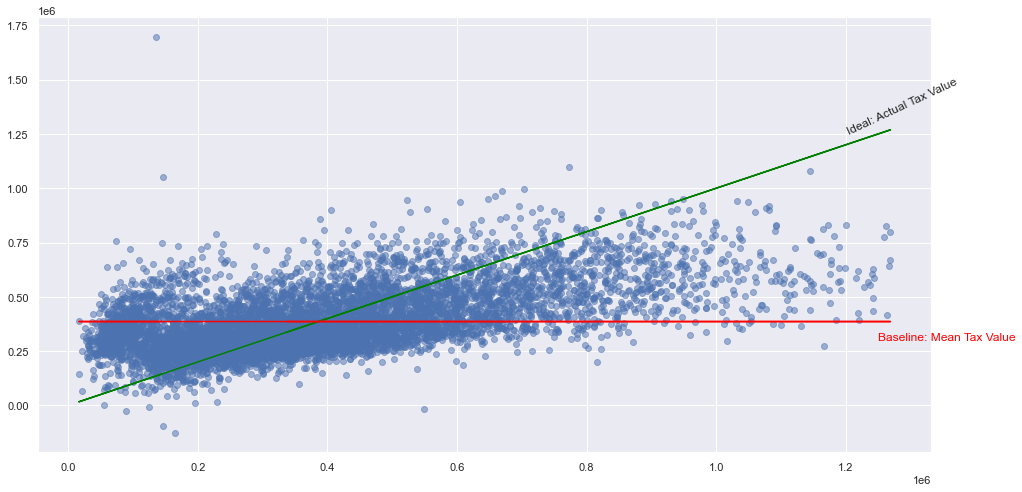

In [103]:
plt.figure(figsize = (16, 8))
plt.plot(y_validate.tax_value, y_validate.tax_value, color = 'green')
plt.plot(y_validate.tax_value, y_validate['baseline_mean_pred'], color = 'red')
plt.scatter(y_validate.tax_value, y_validate['poly_preds_4'], alpha = 0.5)
plt.annotate('Ideal: Actual Tax Value', (1.2*10**6, 1.25*10**6), rotation = 25)
plt.annotate('Baseline: Mean Tax Value', (1.25*10**6, .3*10**6), color = 'red')
plt.show()